In [102]:
#!pip install rouge_score

In [1]:
import os
import json
import torch
import torch.nn as nn
import pandas as pd
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, PegasusConfig
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer


In [2]:
#dataset and tokenizer building
#load our 10k data into a dataframe
papers = []
for root, dirs, files in os.walk("./data/mini_10k"):
    for f in files:
        fn = root+"/"+f
        with open(fn) as jsonfile:
            d = json.load(jsonfile)
        papers.append(d)
        

In [3]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

In [4]:
df = pd.DataFrame(papers)

In [5]:
model_name = 'google/pegasus-large'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
config = PegasusConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)  
amodel = PegasusForConditionalGeneration.from_pretrained(model_name, config=config).to(device)

In [6]:
def heatpatch(data, txt=[], start=0, n=4):
    #show a heatmap slice of what words are being chosen by attn 
    data = data.narrow(0, start, n)
    data = data.narrow(1, start, n)
    heatmap = plt.pcolor(data.cpu().numpy())

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            #print(data[x])
            
            
            
            w = txt[start+x]
            #print(w)
            plt.text(x + 0.5, y + 0.5, w,
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.colorbar(heatmap)
    plt.show()

In [43]:
keywords = []
for i_paper in range(100):
    
    summary,fulltext = df.summary[i_paper],df.fulltext[i_paper]
    batch = tokenizer(fulltext, truncation=True, padding='longest', return_tensors="pt").to(device)
    out = amodel.generate(return_dict_in_generate=True, **batch)
    
    #global_attn = torch.rand(1024,1024).to(device)
    global_attn = torch.zeros(1024,1024).to(device)
    try:
        for i,attn in enumerate(out["encoder_attentions"]):

            if i != len(out["encoder_attentions"]) -1 :
                continue

            for j,block in enumerate(attn[0]):
                #print(block.shape)
                attn = torch.tensor(block)

                global_attn = global_attn.add(attn)
                #global_attn = torch.einsum("ab,cd->bc", global_attn, attn)
                #global_attn = torch.einsum("ab,cd->ad", global_attn, attn)
                #print("{} {}".format(i,j))

                if j > 1:
                    break
    except Exception as e:
        print(e)
        continue
    values,indices = torch.sort(global_attn)
    
    
    
    #print attention with words
#     start = 0
#     step = 4
#     txt = fulltext.split()
#     for x in range(4):
#         heatpatch(global_attn, start=start, txt=txt)
#         start += step
    
    #print a small slice of the attention
#     gsx = global_attn.narrow(0,0,10)
#     gs = gsx.narrow(1,1,10)
#     gs = gs.cpu().detach().numpy()
#     plt.matshow(gs)
#     plt.show()

    

    #print(top_k)
    top_ids = []
    top_k = 256
    for row in indices:
        #print(row.shape)
        for r in range(top_k):
            top_ids.append(row[r])
        break

    #print(top_ids)
    #tgt_text = tokenizer.batch_decode(top_ids, skip_special_tokens=True)
    #print(tgt_text)

    trg = []
    txt = fulltext.split()
    for i in top_ids:
        if i > len(txt):
            break
        x = txt[i]
        trg.append(txt[i])
        
    keywords.append(trg)

#     print("*"*80)
#     print("TARGET WORDS:")
#     print("*"*80)
#     print(" ".join(trg))
#     print("*"*80)
#     #print(p["summary"])

#     #note: great rouge1 scores, can we expand from attention using graph / beam / a*
#     #to find the important sentences? 
#     scores = scorer.score(" ".join(trg), summary)
#     for k in scores:
#         print(k, scores[k])
        
#     break
    
    if i_paper % 100 == 0:
        print("iteration {}".format(i_paper))



/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iteration 0
The size of tensor a (1024) must match the size of tensor b (948) at non-singleton dimension 1


In [44]:
#analysis of effectiveness of keywords
scores = []
for i_paper in range(len(keywords)):
    summary,fulltext = df.summary[i_paper],df.fulltext[i_paper]
    kw = keywords[i_paper]
    score = scorer.score(" ".join(kw), summary)
    x = {}
    for k in score:
        x[k] = score[k][1]
    scores.append(x)

scores_df = pd.DataFrame(scores)

In [45]:
#last add 
scores_df.describe()

rouge1     rouge2
count  99.000000  99.000000
mean    0.276106   0.020437
std     0.146304   0.020425
min     0.028571   0.000000
25%     0.173851   0.004431
50%     0.244980   0.014815
75%     0.375086   0.030361
max     0.661597   0.106870

In [42]:
# last + ab,cd->ad + noise
scores_df.describe()

rouge1     rouge2
count  99.000000  99.000000
mean    0.289964   0.022786
std     0.152341   0.020301
min     0.003876   0.000000
25%     0.182541   0.007519
50%     0.263158   0.019685
75%     0.380616   0.033311
max     0.660156   0.101961

In [31]:
#last + add  ab,cd->bc + noise
scores_df.describe()

rouge1     rouge2
count  99.000000  99.000000
mean    0.263514   0.026398
std     0.140258   0.022989
min     0.000000   0.000000
25%     0.182213   0.007591
50%     0.227437   0.020080
75%     0.353396   0.040148
max     0.748201   0.101449

In [26]:
#last + add  ab,cd->bc + noise
scores_df.describe()

rouge1     rouge2
count  10.000000  10.000000
mean    0.416729   0.055955
std     0.161631   0.022686
min     0.218045   0.034749
25%     0.316652   0.040633
50%     0.401443   0.046171
75%     0.467954   0.071720
max     0.748201   0.101449

In [23]:
#add  + noise
scores_df.describe()

rouge1      rouge2
count  299.000000  299.000000
mean     0.193393    0.010841
std      0.108451    0.013462
min      0.000000    0.000000
25%      0.119627    0.003759
50%      0.176955    0.007663
75%      0.244403    0.012503
max      0.670968    0.130612

In [20]:
#add  + noise
scores_df.describe()

rouge1     rouge2
count  30.000000  30.000000
mean    0.345227   0.029920
std     0.122876   0.018673
min     0.161871   0.007692
25%     0.256952   0.022366
50%     0.327698   0.028599
75%     0.426400   0.033840
max     0.664430   0.113360

In [17]:
#add + ab,cd->ad + noise
scores_df.describe()

rouge1      rouge2
count  299.000000  299.000000
mean     0.193511    0.010138
std      0.103980    0.011915
min      0.000000    0.000000
25%      0.123091    0.003738
50%      0.175510    0.007692
75%      0.235967    0.014439
max      0.645522    0.093878

In [14]:
#add + ab,cd->ad + noise
scores_df.describe()

rouge1     rouge2
count  30.000000  30.000000
mean    0.326176   0.026937
std     0.104203   0.016474
min     0.173554   0.003788
25%     0.253831   0.017183
50%     0.317588   0.023813
75%     0.382231   0.031269
max     0.573171   0.093878

In [9]:
#add + ab,cd->bc + noise
scores_df.describe()

rouge1      rouge2
count  299.000000  299.000000
mean     0.194237    0.012270
std      0.104886    0.014588
min      0.019231    0.000000
25%      0.119139    0.003817
50%      0.175676    0.007752
75%      0.244900    0.015326
max      0.598726    0.099602

torch.Size([4, 4])


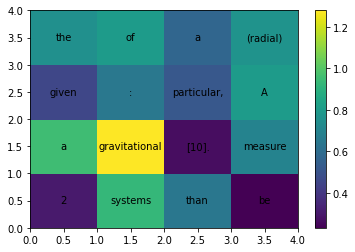

In [143]:
#show a heatmap slice of what words are being chosen by attn 
data = global_attn.narrow(0, 0, 4)
data = data.narrow(1, 0, 4)

print(data.shape)

heatmap = plt.pcolor(data.cpu().numpy())

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        #print(data[x])
        w = txt[indices[y][x]]
        #print(w)
        plt.text(x + 0.5, y + 0.5, w,
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(heatmap)

plt.show()

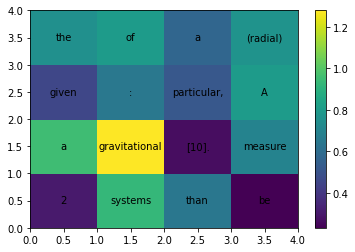

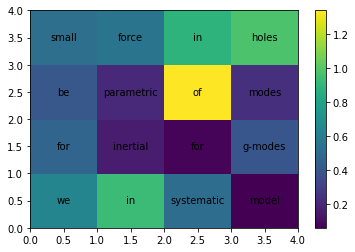

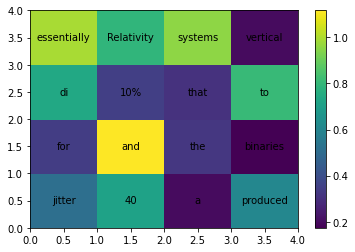

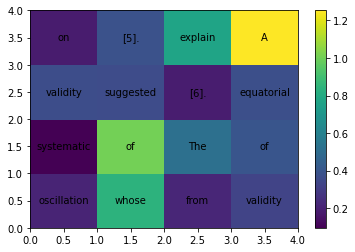

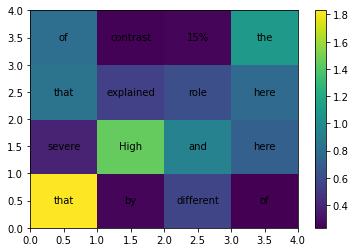

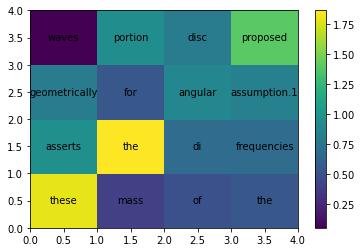

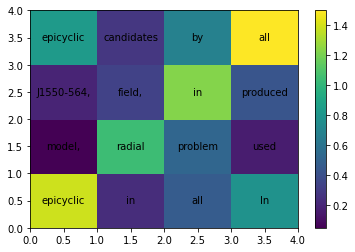

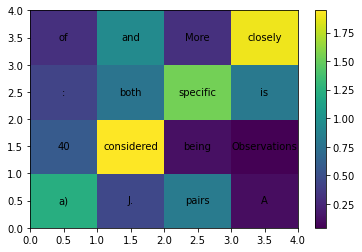

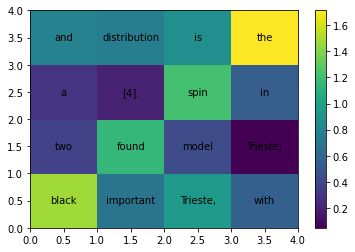

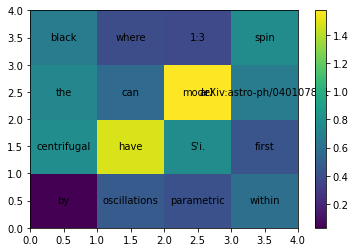

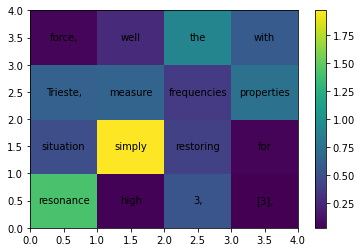

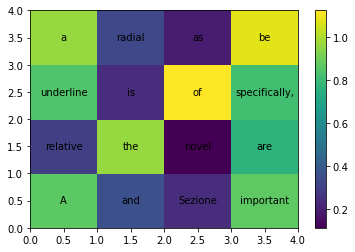

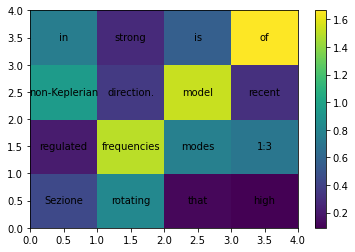

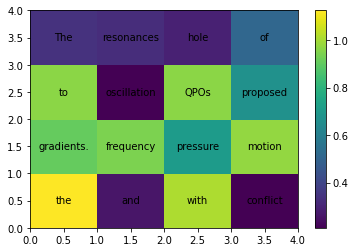

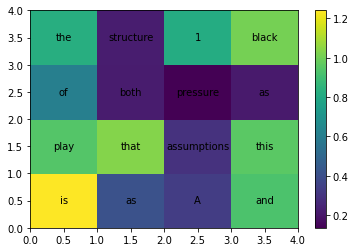

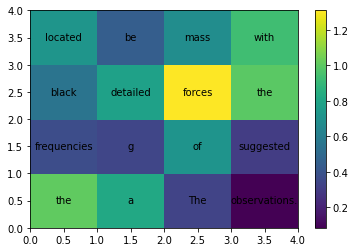

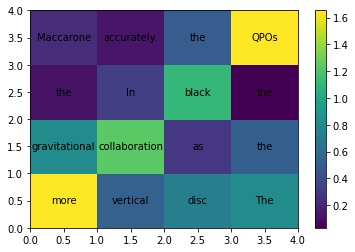

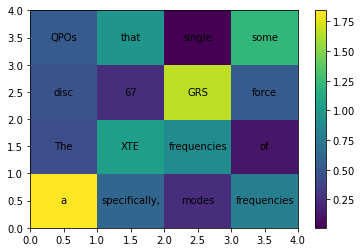

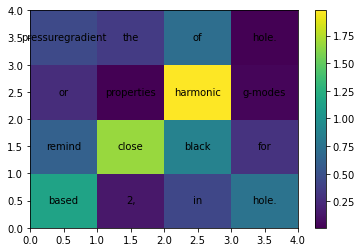

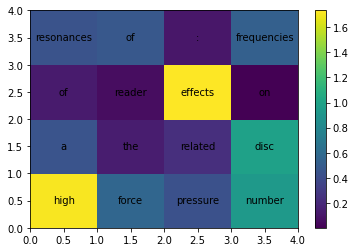

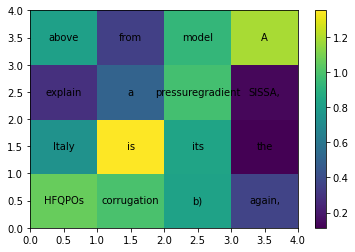

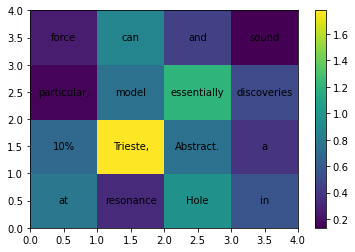

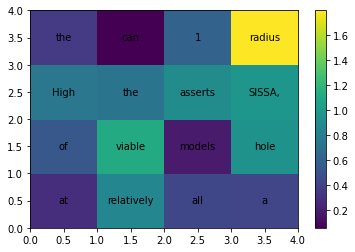

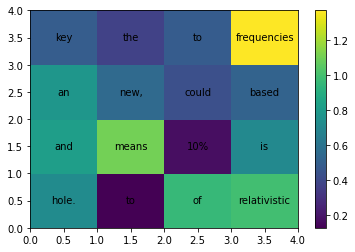

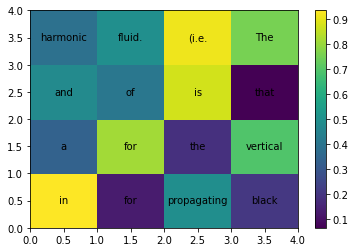

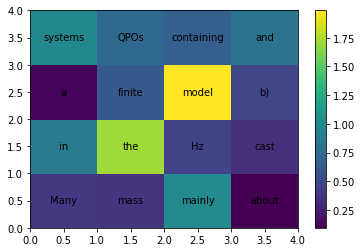

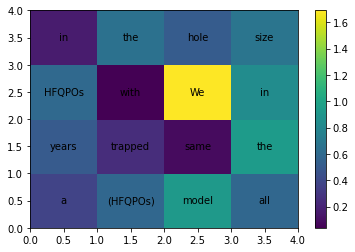

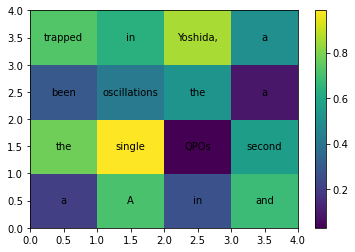

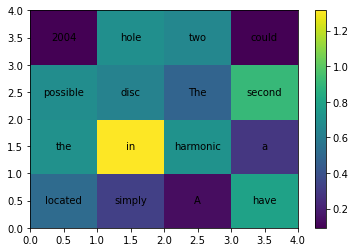

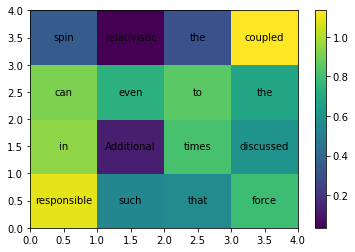

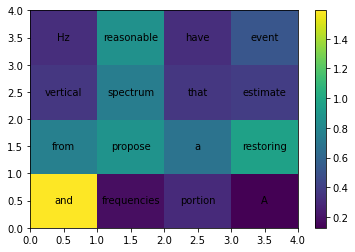

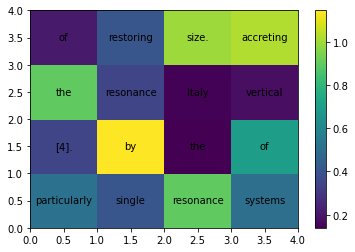

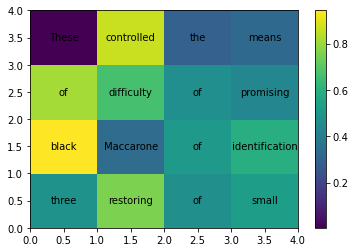

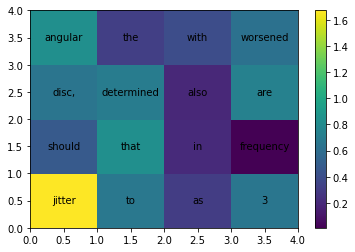

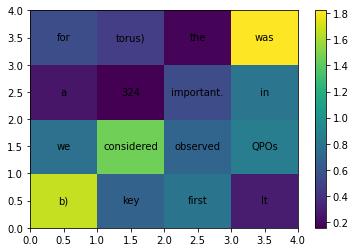

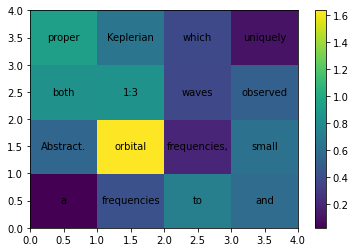

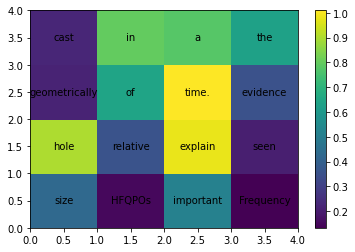

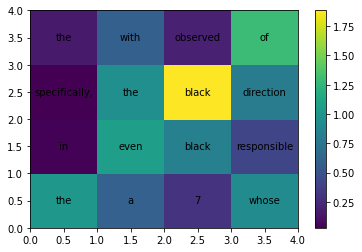

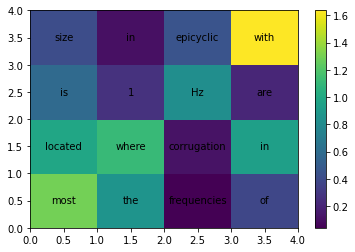

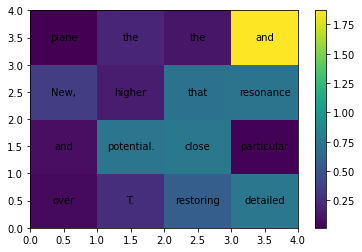

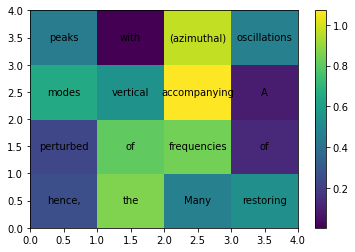

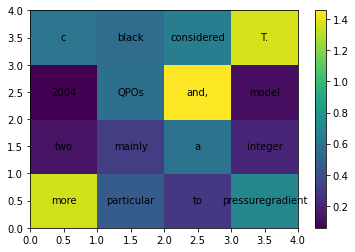

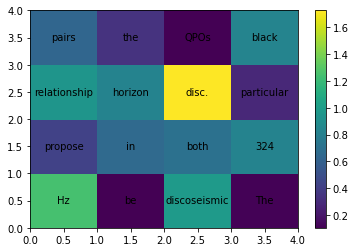

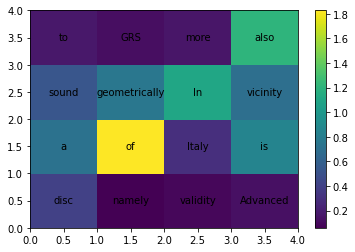

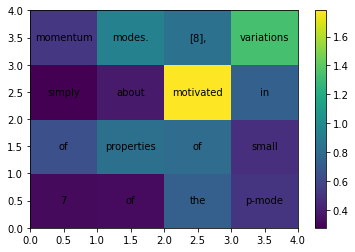

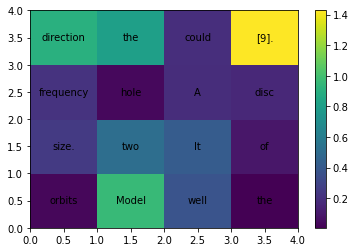

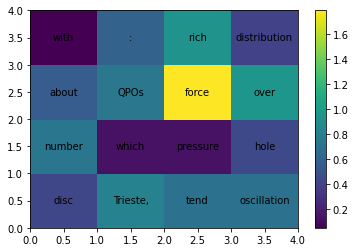

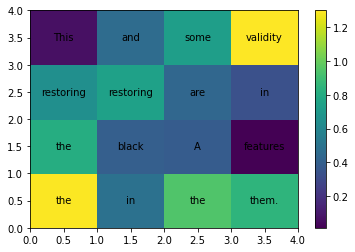

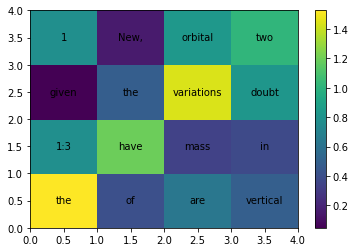

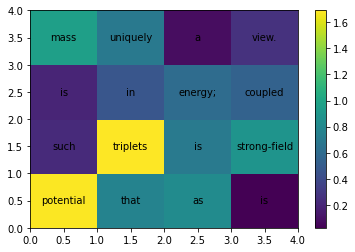

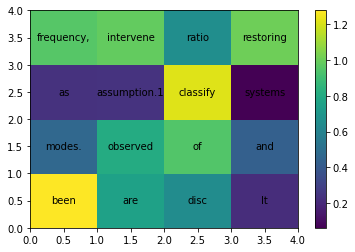

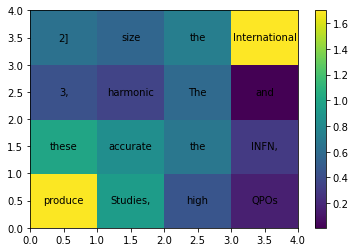

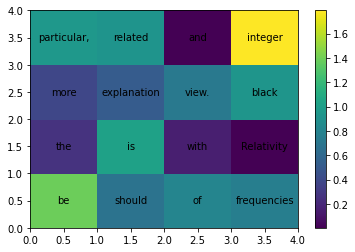

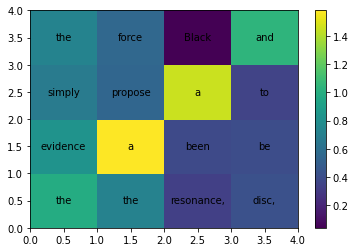

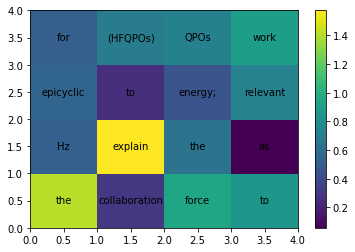

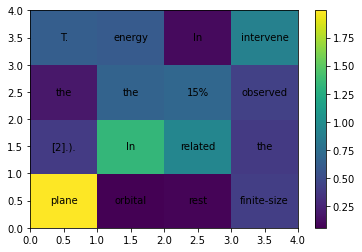

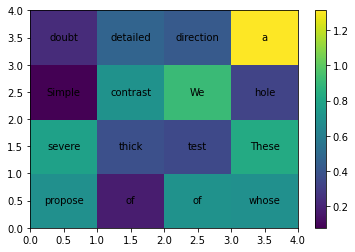

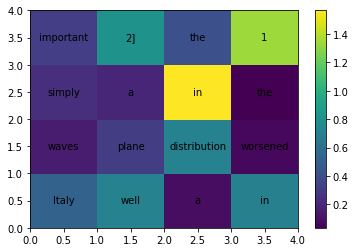

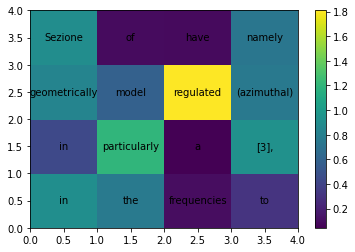

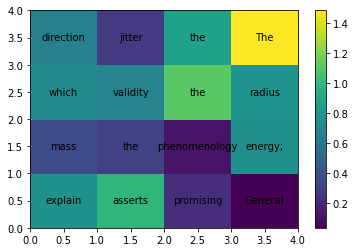

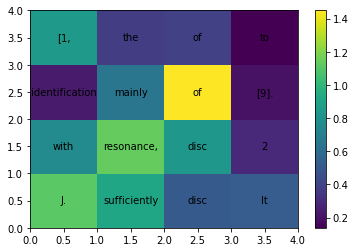

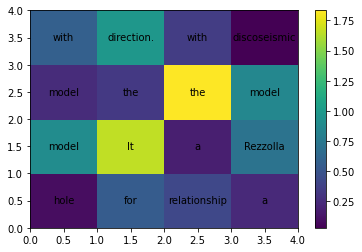

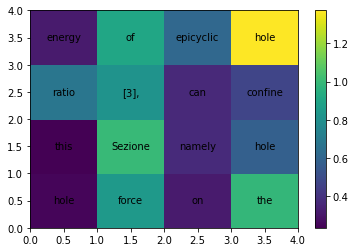

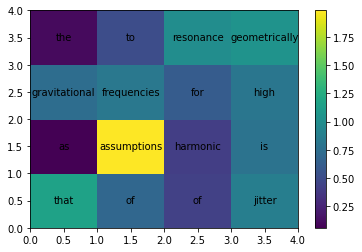

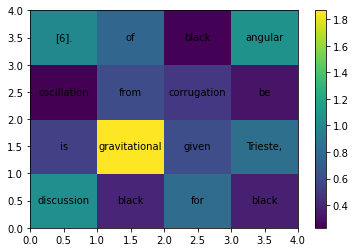

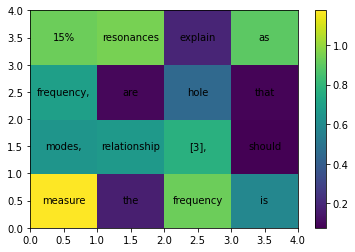

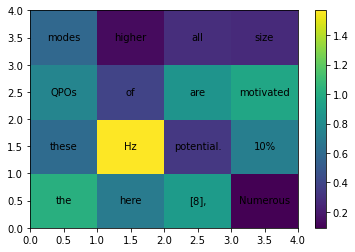

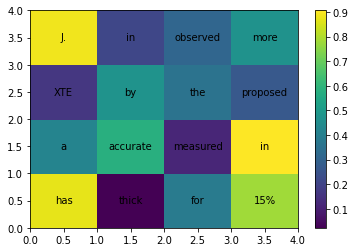

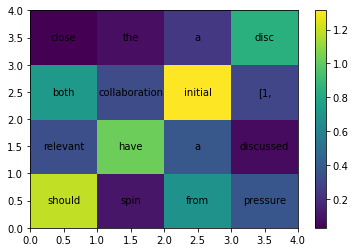

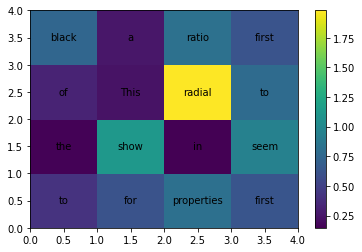

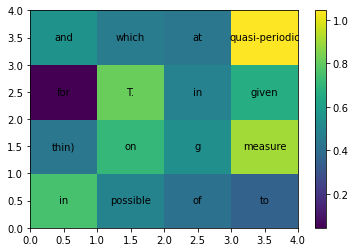

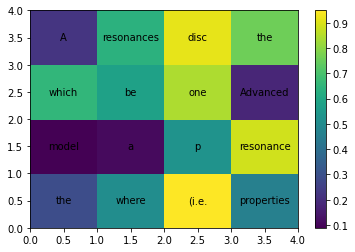

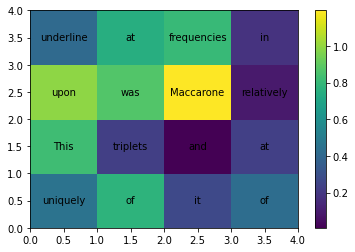

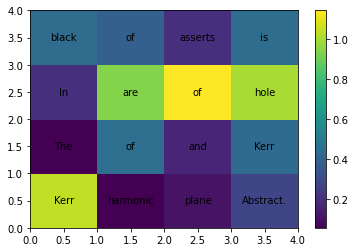

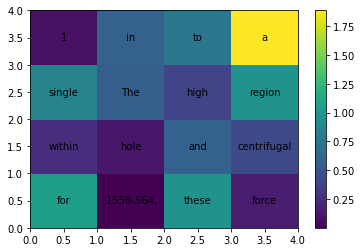

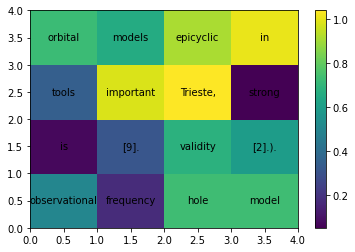

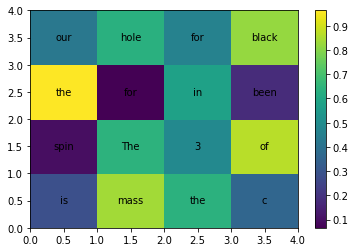

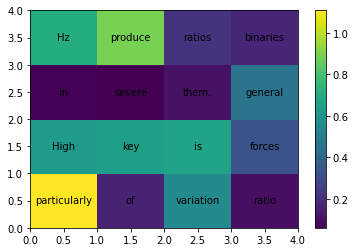

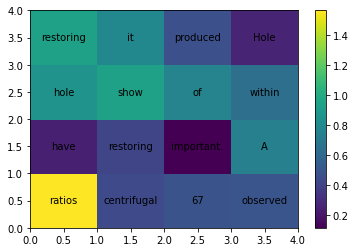

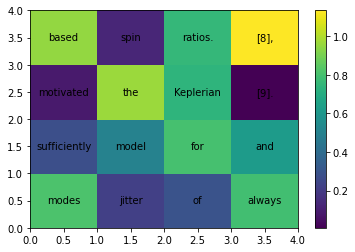

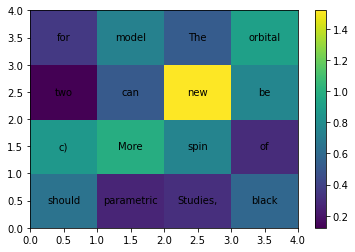

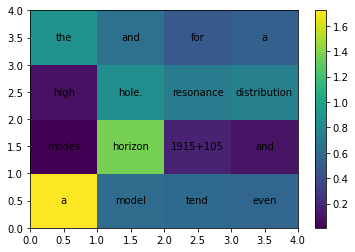

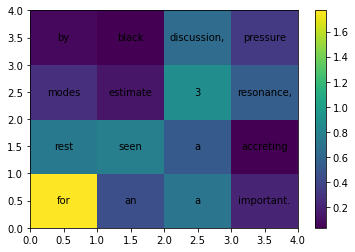

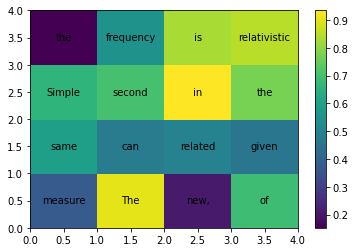

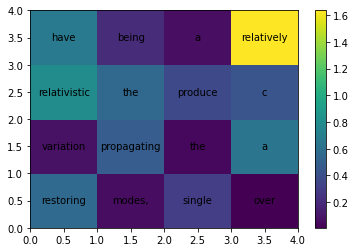

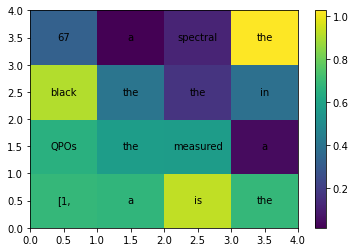

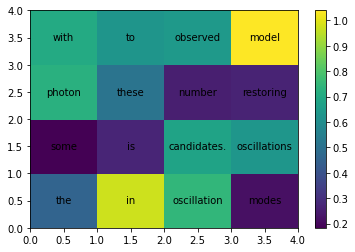

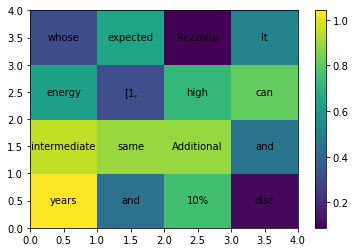

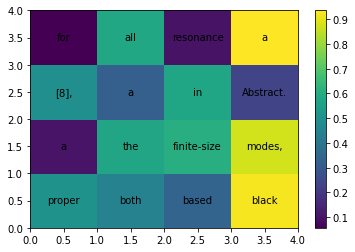

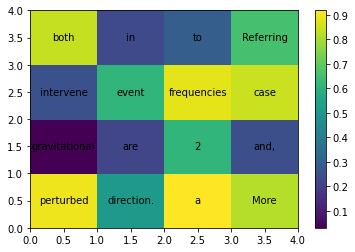

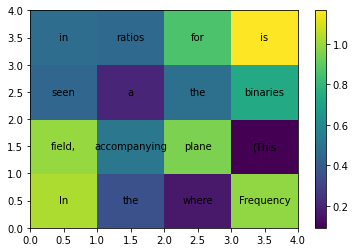

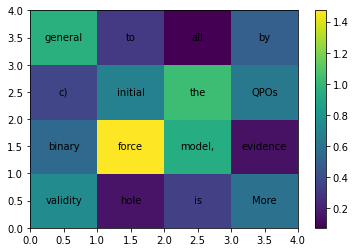

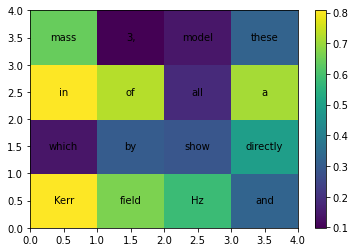

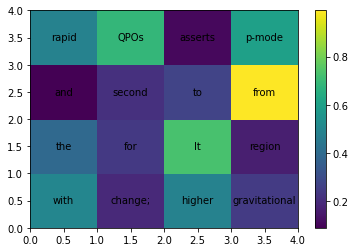

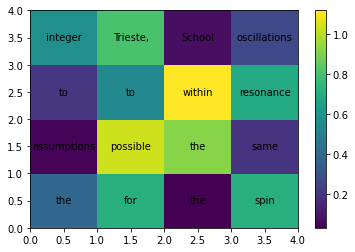

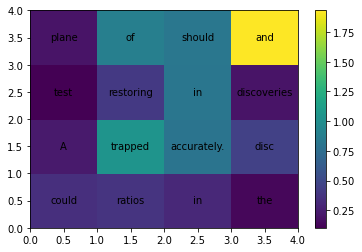

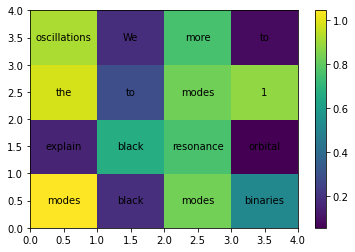

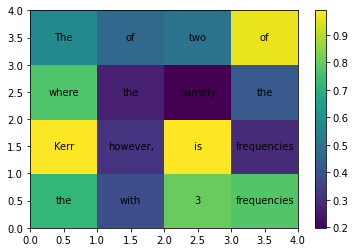

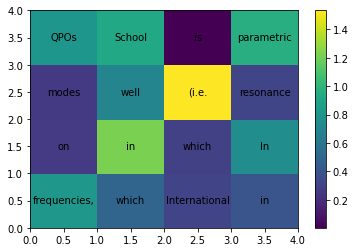

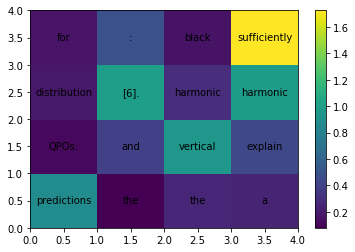

In [146]:
def heatpatch(data, start=0, n=4):
    #show a heatmap slice of what words are being chosen by attn 
    data = data.narrow(0, start, n)
    data = data.narrow(1, start, n)
    heatmap = plt.pcolor(data.cpu().numpy())

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            #print(data[x])
            
            w = txt[indices[start+y][start+x]]
            #print(w)
            plt.text(x + 0.5, y + 0.5, w,
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.colorbar(heatmap)
    plt.show()

start = 0
step = 4
for x in range(100):
    heatpatch(global_attn, start=start)
    start += step

0 torch.Size([8, 16, 1, 1024])
11563 7688


TypeError: Invalid shape (8, 1, 1024) for image data

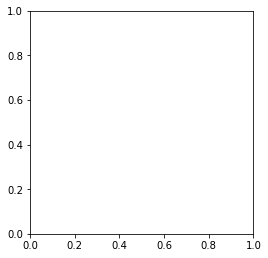

In [33]:
enc_attn, dec_attn = out.cross_attentions[0], out.cross_attentions[1]

for i,x in enumerate(enc_attn):
    print(i, x.shape)
    t = enc_attn[0][i]
    t = out.decoder_hidden_states[i][0].cpu().detach().numpy()
    plt.matshow(t)
plt.show()

In [45]:
print(out.logits.shape)
ma = torch.argmax(out.logits[0][0])
mi = torch.argmin(out.logits[0][0])
print(mi)
print(ma)

tgt_text = tokenizer.batch_decode([mi], skip_special_tokens=True)
print(tgt_text)

tgt_text = tokenizer.batch_decode([ma], skip_special_tokens=True)
print(tgt_text)

ids = []
for log in out.logits[0]:
    ma = torch.argmax(log)
    ids.append(ma)
    
tgt_text = tokenizer.batch_decode(ids, skip_special_tokens=True)
print(tgt_text)

torch.Size([1, 1024, 96103])
tensor(92747, device='cuda:0')
tensor(202, device='cuda:0')
['AnyFormat']
['A']
['A', 'A', 'A', 'A', 'A', 'Ap', 'Ap', 'Ap', 'Ap', 'A', 'Ap', 'Ap', 'Ap', 'Ap', '<n>', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'A', 'A', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'Ap', 'A', 'Ap', 'A', 'A', 'A', '.', 'a', 'Studies', '.', '.', ',', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '...', 's', '.', '.', '.', '...', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'of', '.', '.', '.', '.', '.', '.', '.', '.', '...', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', '.', '.', '.', '.', '.', 'the', '.', ')', 'been', ').', ').', 'a', ').', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'The', '[...]', '[...]', '[...]', '[...]', '[...]', '[...]', 'part', '.', 'the', 'the', '.', '.', '.', '.', '.', '“', '.', '.',

0 torch.Size([1024, 1024])


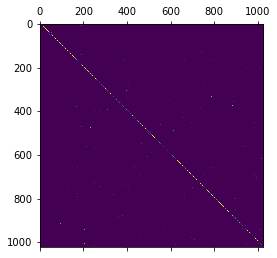

0 torch.Size([1024, 1024])


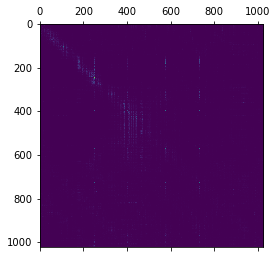

0 torch.Size([1024, 1024])


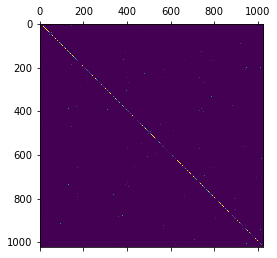

0 torch.Size([1024, 1024])


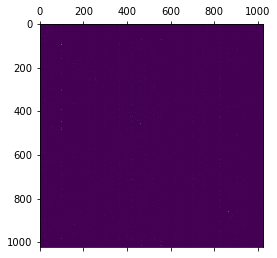

0 torch.Size([1024, 1024])


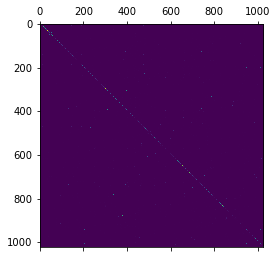

0 torch.Size([1024, 1024])


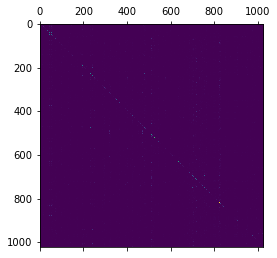

0 torch.Size([1024, 1024])


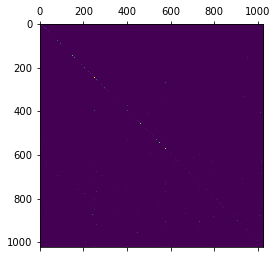

0 torch.Size([1024, 1024])


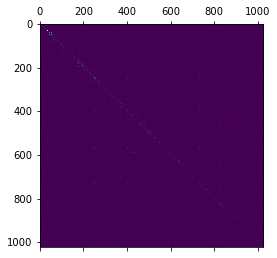

0 torch.Size([1024, 1024])


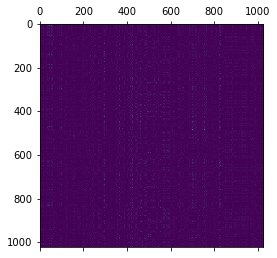

0 torch.Size([1024, 1024])


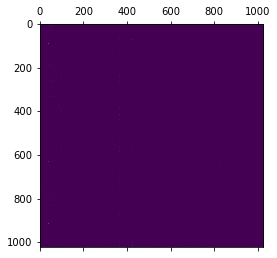

0 torch.Size([1024, 1024])


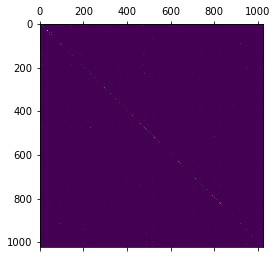

0 torch.Size([1024, 1024])


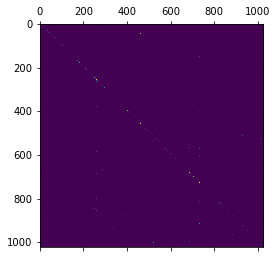

0 torch.Size([1024, 1024])


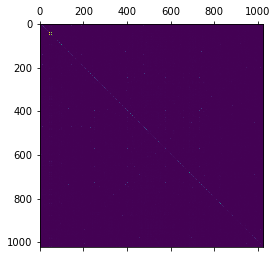

0 torch.Size([1024, 1024])


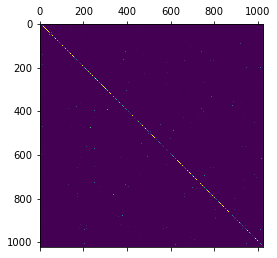

0 torch.Size([1024, 1024])


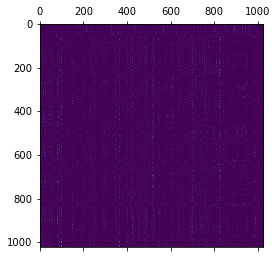

0 torch.Size([1024, 1024])


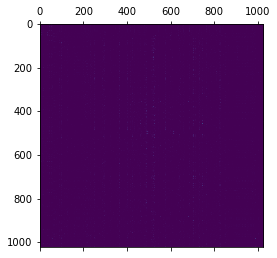

top 99 551
1 torch.Size([1024, 1024])


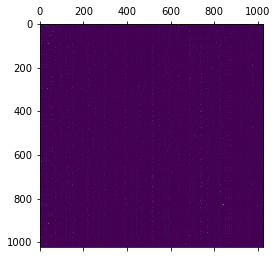

1 torch.Size([1024, 1024])


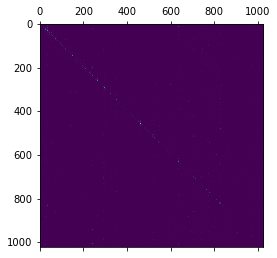

1 torch.Size([1024, 1024])


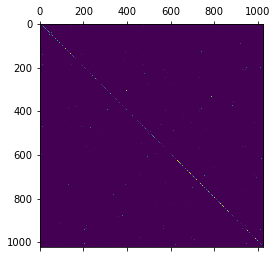

1 torch.Size([1024, 1024])


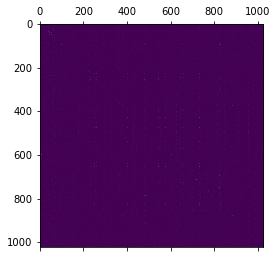

1 torch.Size([1024, 1024])


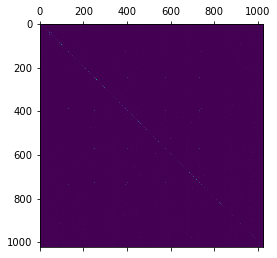

1 torch.Size([1024, 1024])


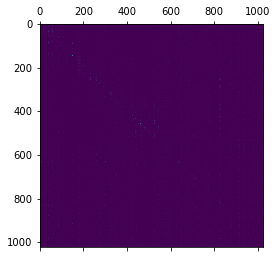

1 torch.Size([1024, 1024])


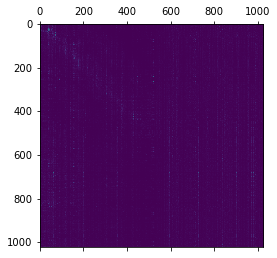

1 torch.Size([1024, 1024])


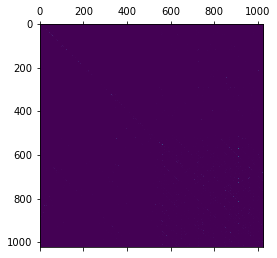

1 torch.Size([1024, 1024])


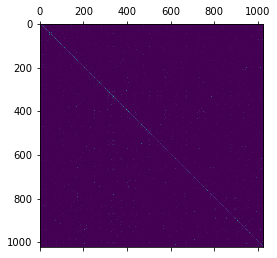

1 torch.Size([1024, 1024])


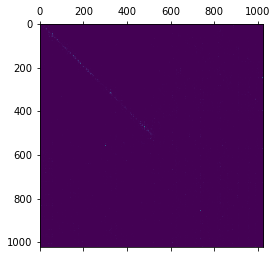

1 torch.Size([1024, 1024])


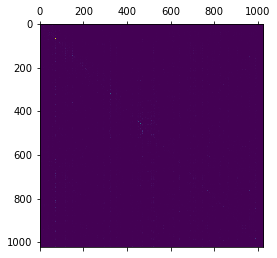

1 torch.Size([1024, 1024])


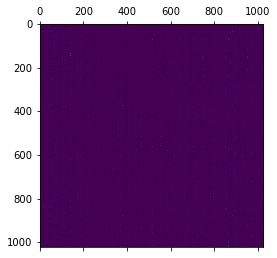

1 torch.Size([1024, 1024])


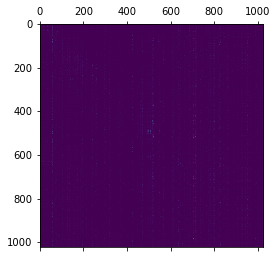

1 torch.Size([1024, 1024])


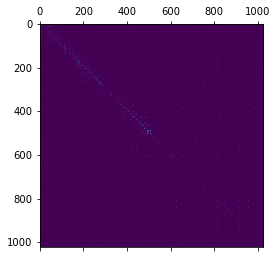

1 torch.Size([1024, 1024])


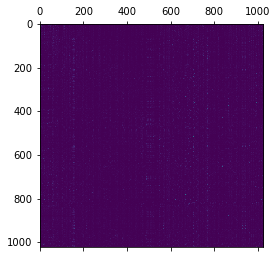

1 torch.Size([1024, 1024])


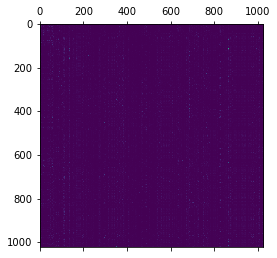

top 99 551


In [157]:
for i,hs in enumerate(out["encoder_attentions"]):
    for hss in hs[0]:
        print(i, hss.shape)
        t = hss.cpu().detach().numpy()
        plt.matshow(t)
        plt.show()
    
    #x = torch.max(hs[0][0])
    #xi = torch.argmax(hs[0][0])
    
    #low_w,low_idx = torch.min(hs)
    print("top {} {}".format(x, xi))
    if i == 1:
        break

0 torch.Size([8, 1, 1024])


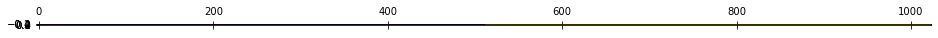

1 torch.Size([8, 1, 1024])


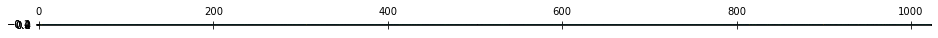

2 torch.Size([8, 1, 1024])


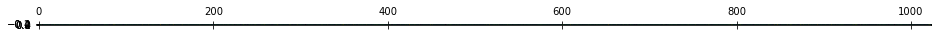

3 torch.Size([8, 1, 1024])


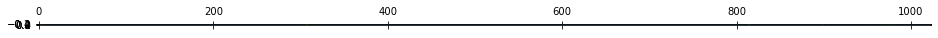

4 torch.Size([8, 1, 1024])


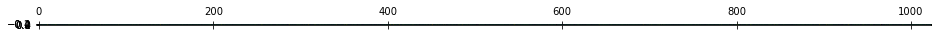

5 torch.Size([8, 1, 1024])


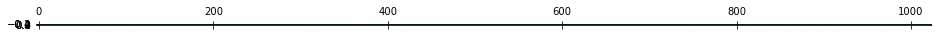

6 torch.Size([8, 1, 1024])


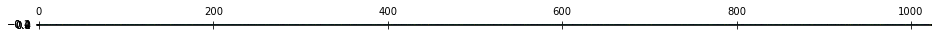

7 torch.Size([8, 1, 1024])


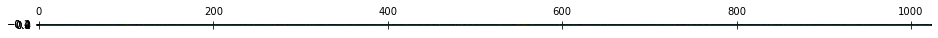

8 torch.Size([8, 1, 1024])


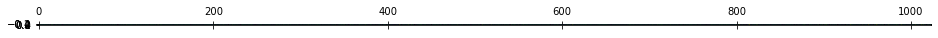

9 torch.Size([8, 1, 1024])


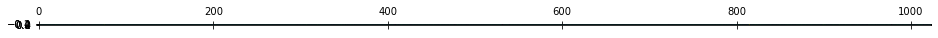

10 torch.Size([8, 1, 1024])


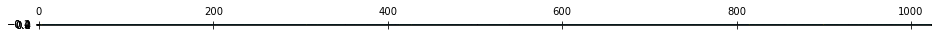

11 torch.Size([8, 1, 1024])


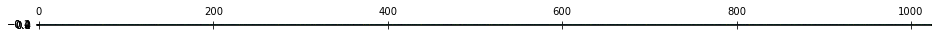

12 torch.Size([8, 1, 1024])


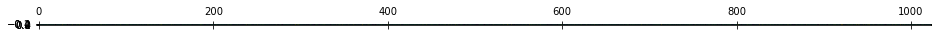

13 torch.Size([8, 1, 1024])


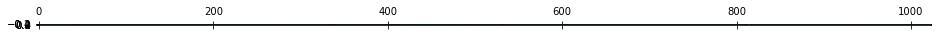

14 torch.Size([8, 1, 1024])


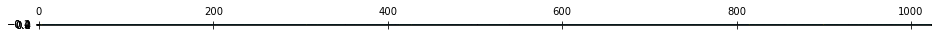

15 torch.Size([8, 1, 1024])


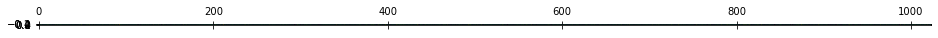

16 torch.Size([8, 1, 1024])


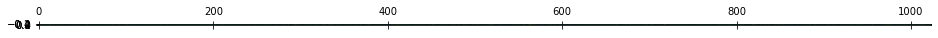

17 torch.Size([8, 1, 1024])


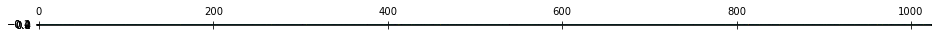

18 torch.Size([8, 1, 1024])


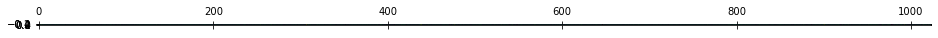

19 torch.Size([8, 1, 1024])


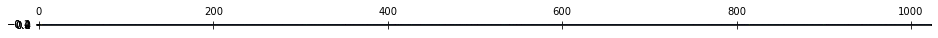

20 torch.Size([8, 1, 1024])


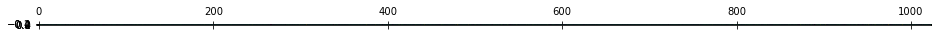

21 torch.Size([8, 1, 1024])


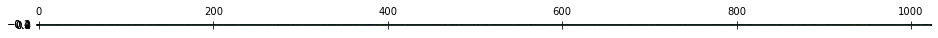

22 torch.Size([8, 1, 1024])


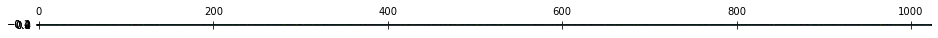

23 torch.Size([8, 1, 1024])


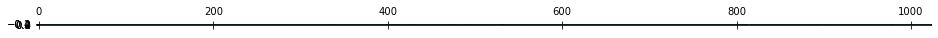

24 torch.Size([8, 1, 1024])


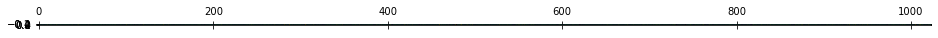

25 torch.Size([8, 1, 1024])


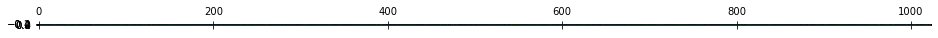

26 torch.Size([8, 1, 1024])


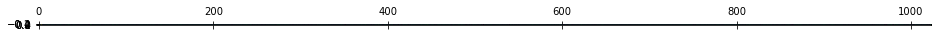

27 torch.Size([8, 1, 1024])


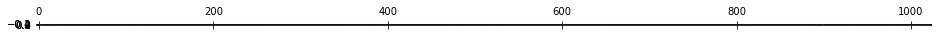

28 torch.Size([8, 1, 1024])


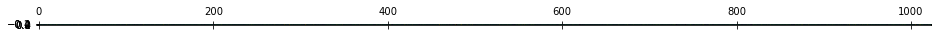

29 torch.Size([8, 1, 1024])


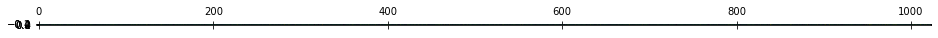

30 torch.Size([8, 1, 1024])


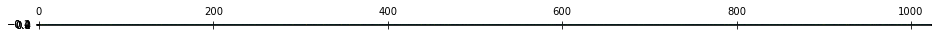

31 torch.Size([8, 1, 1024])


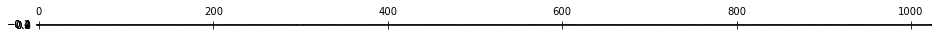

32 torch.Size([8, 1, 1024])


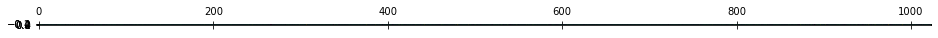

33 torch.Size([8, 1, 1024])


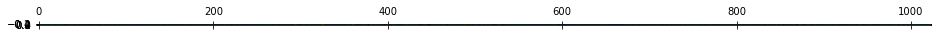

34 torch.Size([8, 1, 1024])


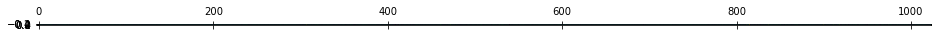

35 torch.Size([8, 1, 1024])


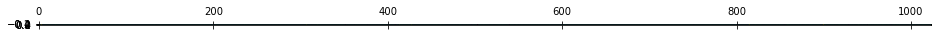

36 torch.Size([8, 1, 1024])


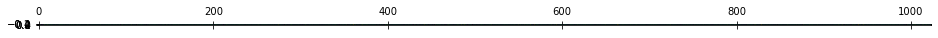

37 torch.Size([8, 1, 1024])


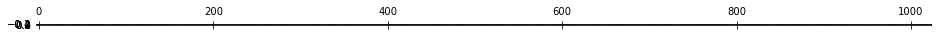

38 torch.Size([8, 1, 1024])


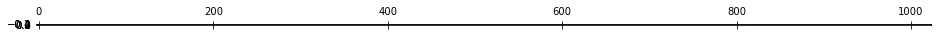

39 torch.Size([8, 1, 1024])


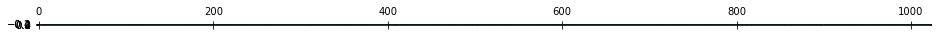

40 torch.Size([8, 1, 1024])


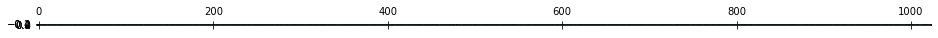

41 torch.Size([8, 1, 1024])


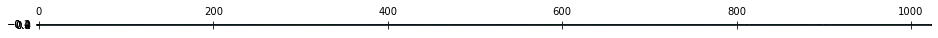

42 torch.Size([8, 1, 1024])


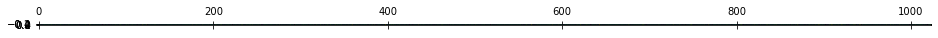

43 torch.Size([8, 1, 1024])


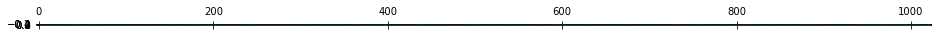

44 torch.Size([8, 1, 1024])


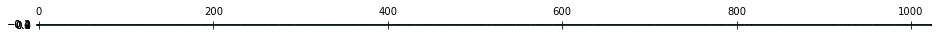

45 torch.Size([8, 1, 1024])


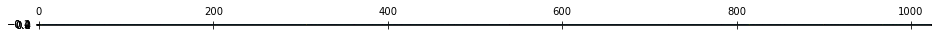

46 torch.Size([8, 1, 1024])


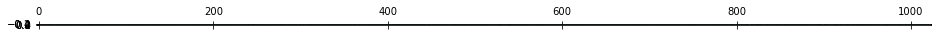

47 torch.Size([8, 1, 1024])


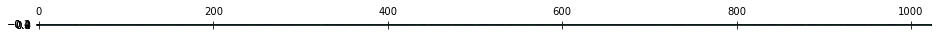

48 torch.Size([8, 1, 1024])


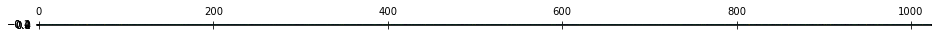

49 torch.Size([8, 1, 1024])


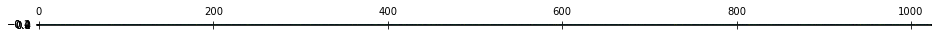

50 torch.Size([8, 1, 1024])


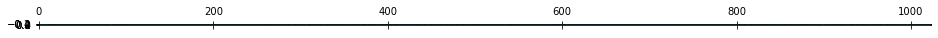

51 torch.Size([8, 1, 1024])


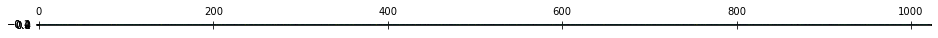

52 torch.Size([8, 1, 1024])


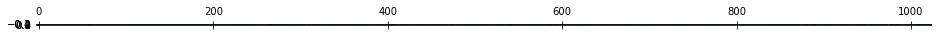

53 torch.Size([8, 1, 1024])


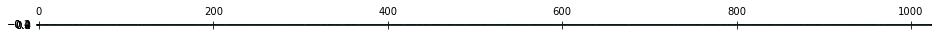

54 torch.Size([8, 1, 1024])


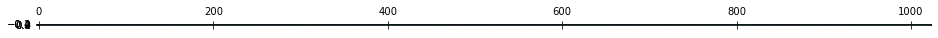

55 torch.Size([8, 1, 1024])


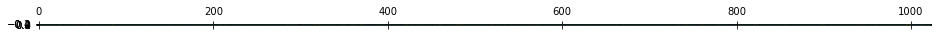

56 torch.Size([8, 1, 1024])


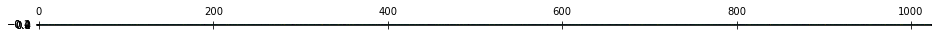

57 torch.Size([8, 1, 1024])


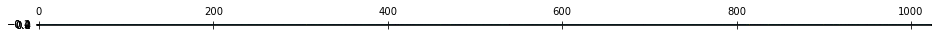

58 torch.Size([8, 1, 1024])


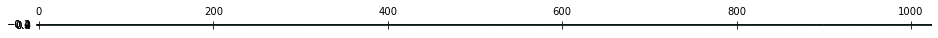

59 torch.Size([8, 1, 1024])


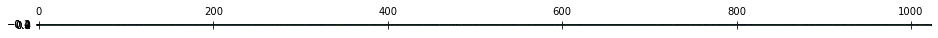

60 torch.Size([8, 1, 1024])


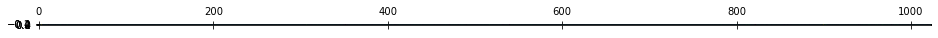

61 torch.Size([8, 1, 1024])


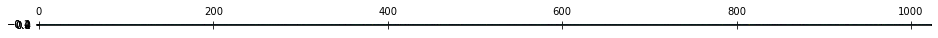

62 torch.Size([8, 1, 1024])


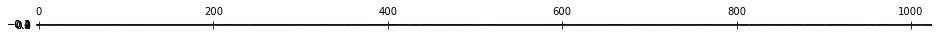

63 torch.Size([8, 1, 1024])


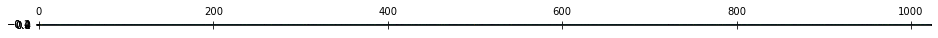

64 torch.Size([8, 1, 1024])


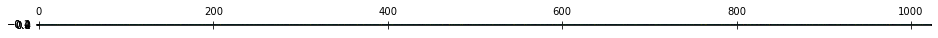

65 torch.Size([8, 1, 1024])


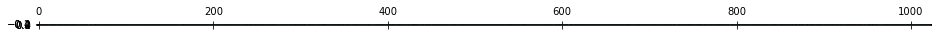

66 torch.Size([8, 1, 1024])


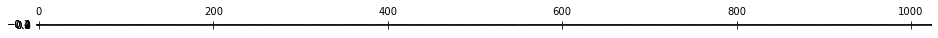

67 torch.Size([8, 1, 1024])


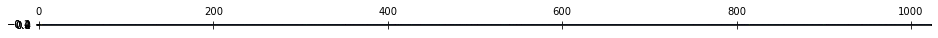

68 torch.Size([8, 1, 1024])


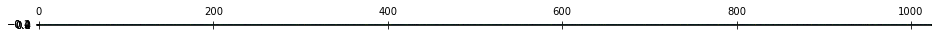

69 torch.Size([8, 1, 1024])


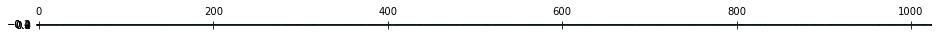

70 torch.Size([8, 1, 1024])


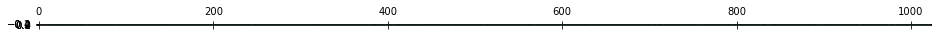

71 torch.Size([8, 1, 1024])


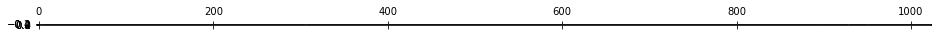

72 torch.Size([8, 1, 1024])


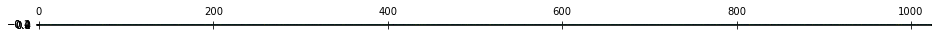

73 torch.Size([8, 1, 1024])


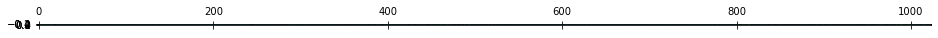

74 torch.Size([8, 1, 1024])


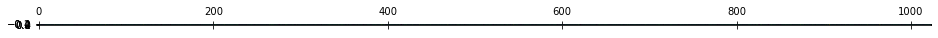

75 torch.Size([8, 1, 1024])


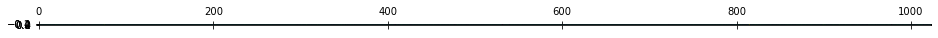

76 torch.Size([8, 1, 1024])


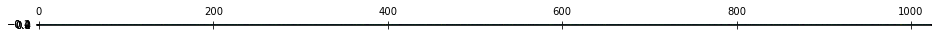

77 torch.Size([8, 1, 1024])


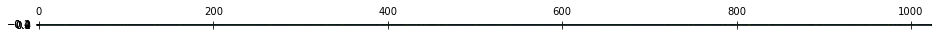

78 torch.Size([8, 1, 1024])


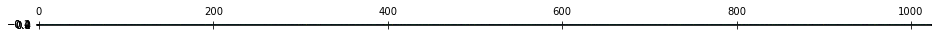

79 torch.Size([8, 1, 1024])


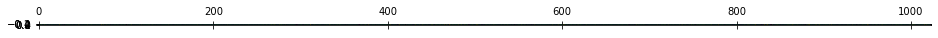

80 torch.Size([8, 1, 1024])


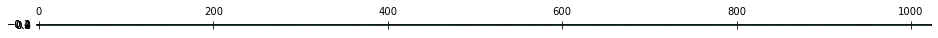

81 torch.Size([8, 1, 1024])


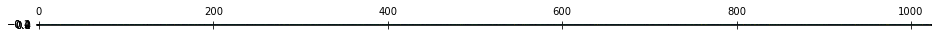

82 torch.Size([8, 1, 1024])


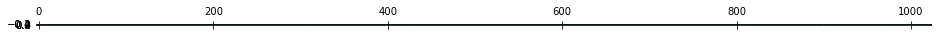

83 torch.Size([8, 1, 1024])


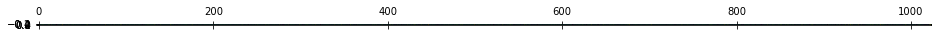

84 torch.Size([8, 1, 1024])


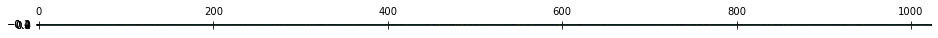

85 torch.Size([8, 1, 1024])


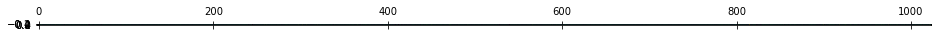

86 torch.Size([8, 1, 1024])


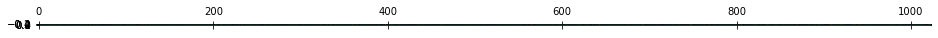

87 torch.Size([8, 1, 1024])


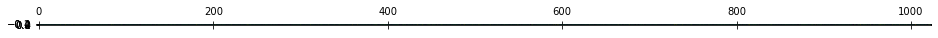

88 torch.Size([8, 1, 1024])


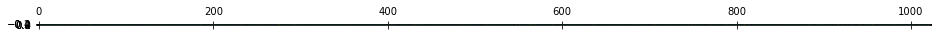

89 torch.Size([8, 1, 1024])


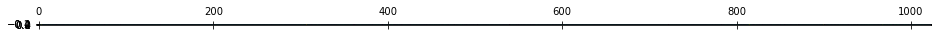

90 torch.Size([8, 1, 1024])


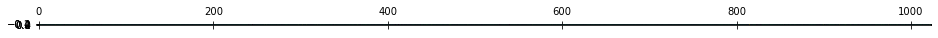

91 torch.Size([8, 1, 1024])


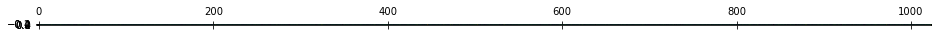

92 torch.Size([8, 1, 1024])


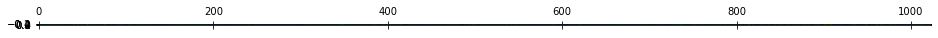

93 torch.Size([8, 1, 1024])


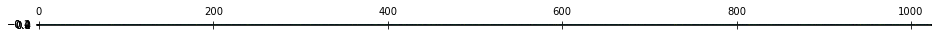

94 torch.Size([8, 1, 1024])


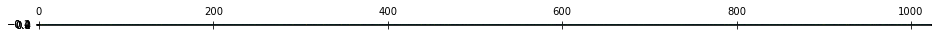

95 torch.Size([8, 1, 1024])


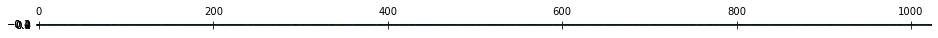

96 torch.Size([8, 1, 1024])


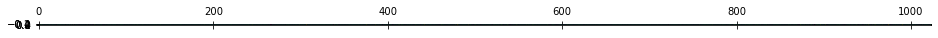

97 torch.Size([8, 1, 1024])


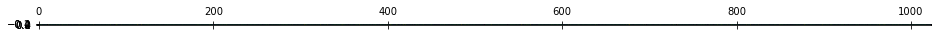

98 torch.Size([8, 1, 1024])


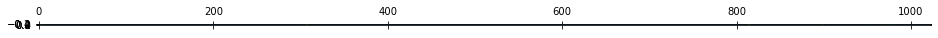

99 torch.Size([8, 1, 1024])


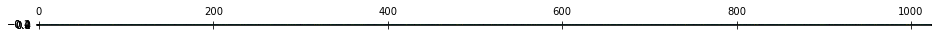

100 torch.Size([8, 1, 1024])


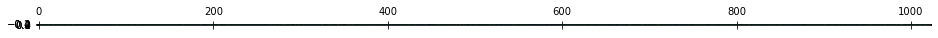

101 torch.Size([8, 1, 1024])


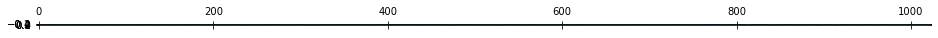

102 torch.Size([8, 1, 1024])


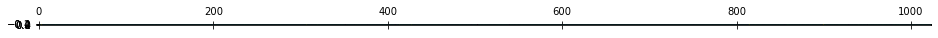

103 torch.Size([8, 1, 1024])


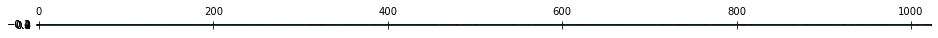

104 torch.Size([8, 1, 1024])


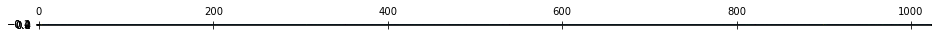

105 torch.Size([8, 1, 1024])


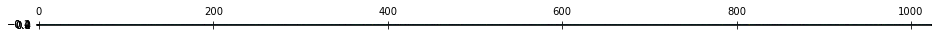

106 torch.Size([8, 1, 1024])


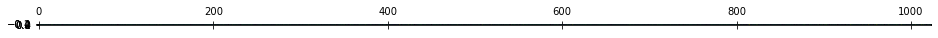

107 torch.Size([8, 1, 1024])


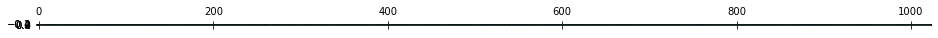

108 torch.Size([8, 1, 1024])


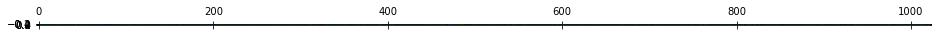

109 torch.Size([8, 1, 1024])


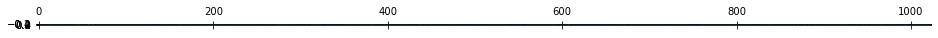

110 torch.Size([8, 1, 1024])


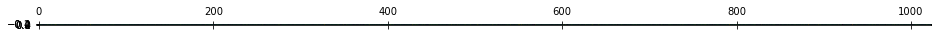

111 torch.Size([8, 1, 1024])


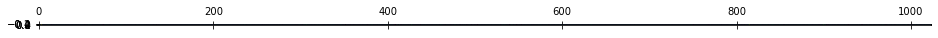

112 torch.Size([8, 1, 1024])


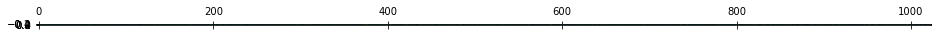

113 torch.Size([8, 1, 1024])


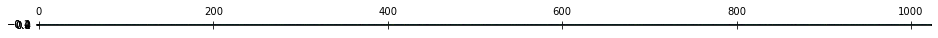

114 torch.Size([8, 1, 1024])


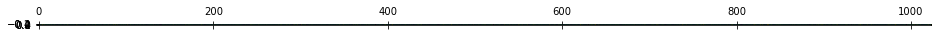

115 torch.Size([8, 1, 1024])


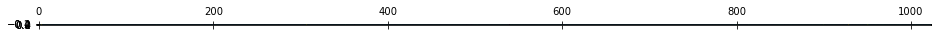

116 torch.Size([8, 1, 1024])


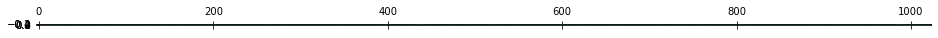

117 torch.Size([8, 1, 1024])


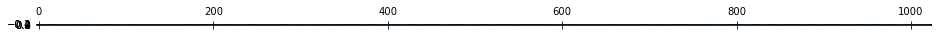

118 torch.Size([8, 1, 1024])


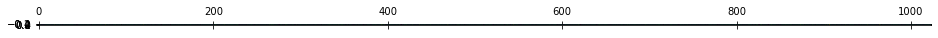

119 torch.Size([8, 1, 1024])


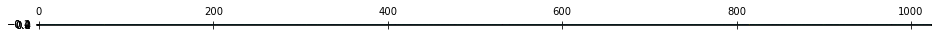

120 torch.Size([8, 1, 1024])


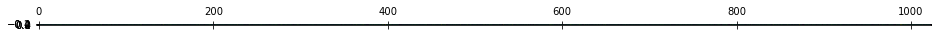

121 torch.Size([8, 1, 1024])


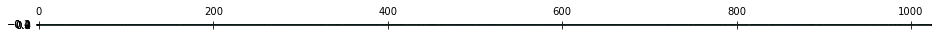

122 torch.Size([8, 1, 1024])


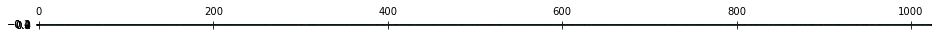

123 torch.Size([8, 1, 1024])


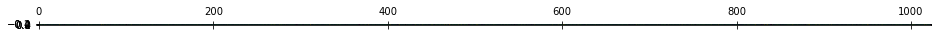

124 torch.Size([8, 1, 1024])


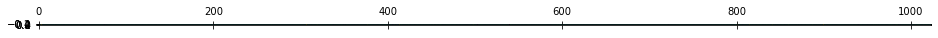

125 torch.Size([8, 1, 1024])


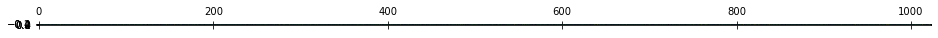

126 torch.Size([8, 1, 1024])


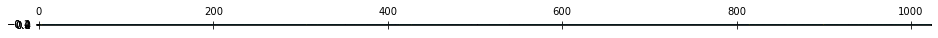

127 torch.Size([8, 1, 1024])


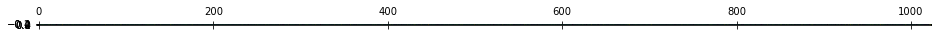

128 torch.Size([8, 1, 1024])


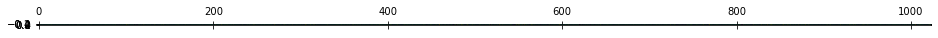

129 torch.Size([8, 1, 1024])


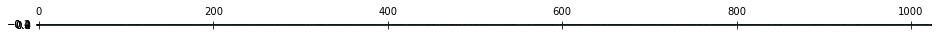

130 torch.Size([8, 1, 1024])


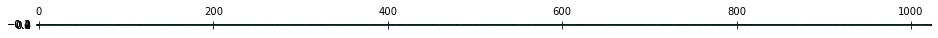

131 torch.Size([8, 1, 1024])


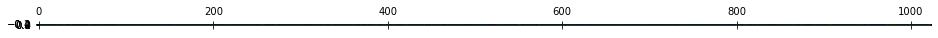

132 torch.Size([8, 1, 1024])


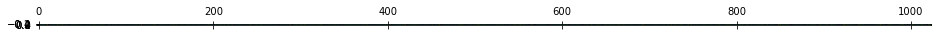

133 torch.Size([8, 1, 1024])


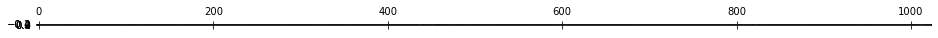

134 torch.Size([8, 1, 1024])


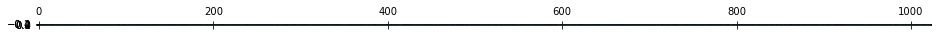

135 torch.Size([8, 1, 1024])


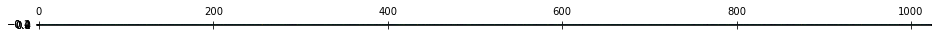

136 torch.Size([8, 1, 1024])


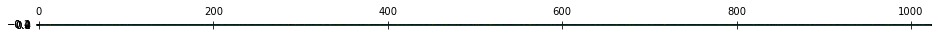

137 torch.Size([8, 1, 1024])


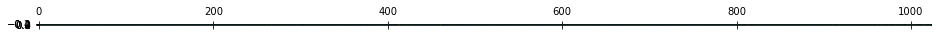

138 torch.Size([8, 1, 1024])


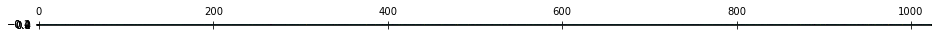

139 torch.Size([8, 1, 1024])


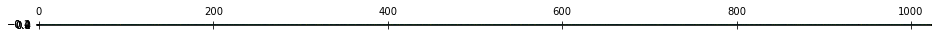

140 torch.Size([8, 1, 1024])


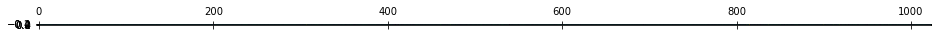

141 torch.Size([8, 1, 1024])


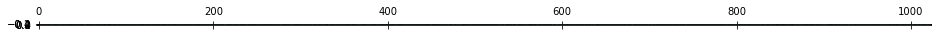

142 torch.Size([8, 1, 1024])


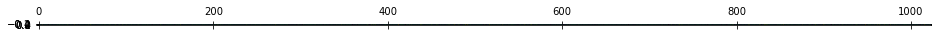

143 torch.Size([8, 1, 1024])


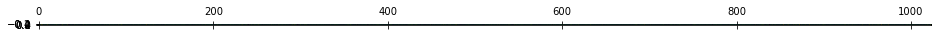

144 torch.Size([8, 1, 1024])


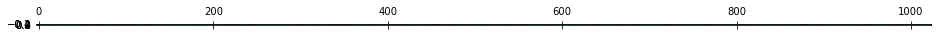

145 torch.Size([8, 1, 1024])


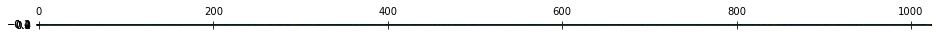

146 torch.Size([8, 1, 1024])


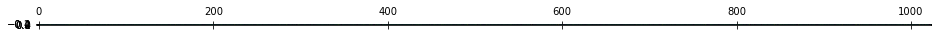

147 torch.Size([8, 1, 1024])


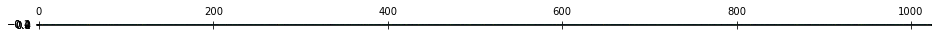

148 torch.Size([8, 1, 1024])


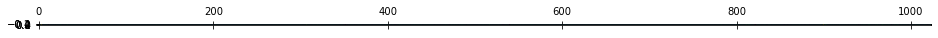

149 torch.Size([8, 1, 1024])


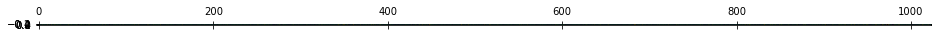

150 torch.Size([8, 1, 1024])


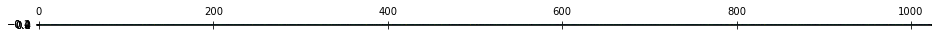

151 torch.Size([8, 1, 1024])


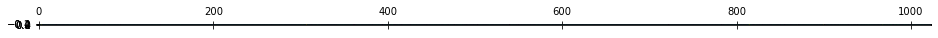

152 torch.Size([8, 1, 1024])


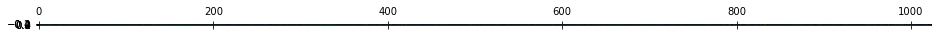

153 torch.Size([8, 1, 1024])


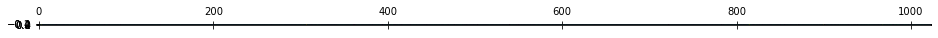

154 torch.Size([8, 1, 1024])


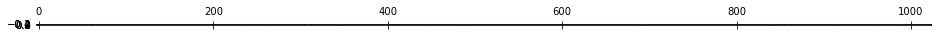

155 torch.Size([8, 1, 1024])


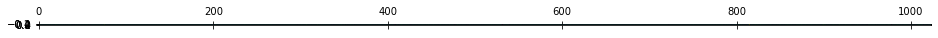

156 torch.Size([8, 1, 1024])


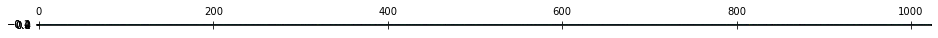

157 torch.Size([8, 1, 1024])


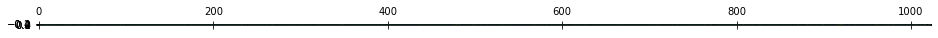

158 torch.Size([8, 1, 1024])


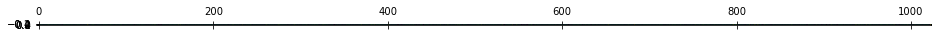

159 torch.Size([8, 1, 1024])


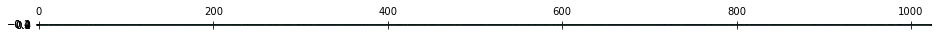

160 torch.Size([8, 1, 1024])


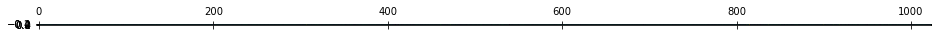

161 torch.Size([8, 1, 1024])


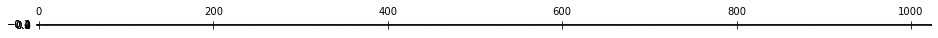

162 torch.Size([8, 1, 1024])


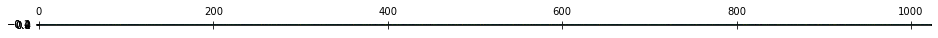

163 torch.Size([8, 1, 1024])


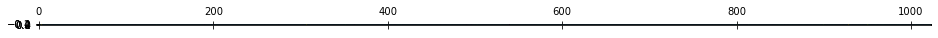

164 torch.Size([8, 1, 1024])


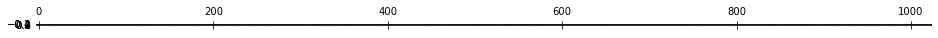

165 torch.Size([8, 1, 1024])


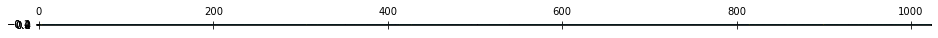

166 torch.Size([8, 1, 1024])


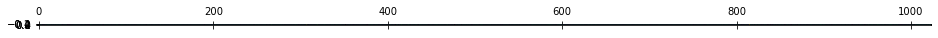

167 torch.Size([8, 1, 1024])


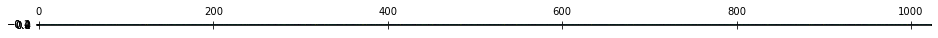

168 torch.Size([8, 1, 1024])


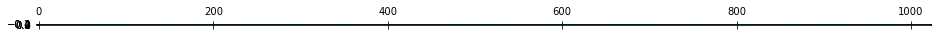

169 torch.Size([8, 1, 1024])


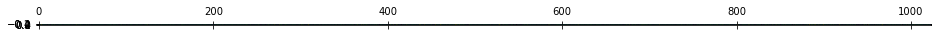

170 torch.Size([8, 1, 1024])


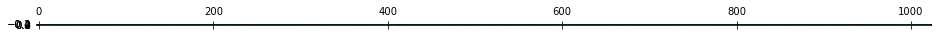

171 torch.Size([8, 1, 1024])


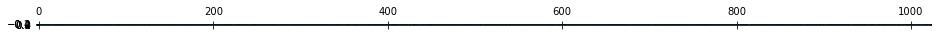

172 torch.Size([8, 1, 1024])


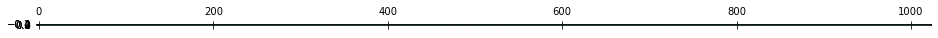

173 torch.Size([8, 1, 1024])


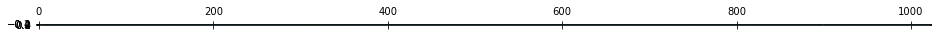

174 torch.Size([8, 1, 1024])


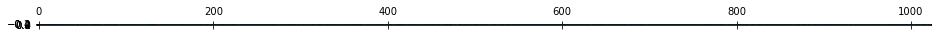

175 torch.Size([8, 1, 1024])


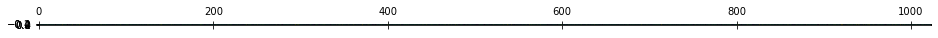

176 torch.Size([8, 1, 1024])


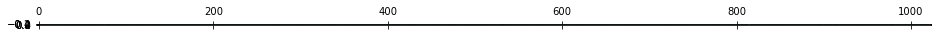

177 torch.Size([8, 1, 1024])


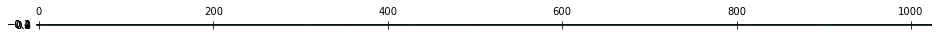

178 torch.Size([8, 1, 1024])


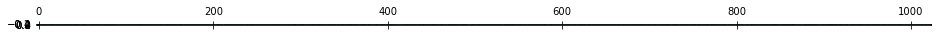

179 torch.Size([8, 1, 1024])


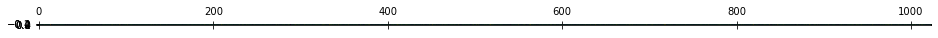

180 torch.Size([8, 1, 1024])


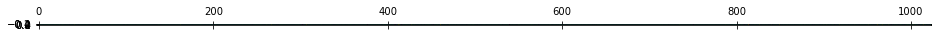

181 torch.Size([8, 1, 1024])


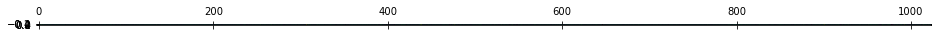

182 torch.Size([8, 1, 1024])


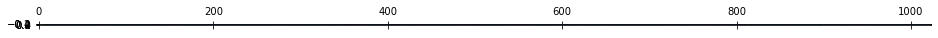

183 torch.Size([8, 1, 1024])


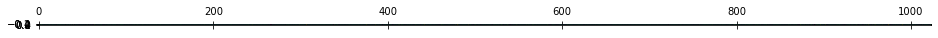

184 torch.Size([8, 1, 1024])


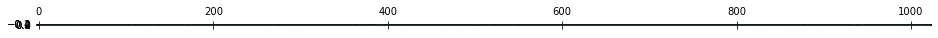

185 torch.Size([8, 1, 1024])


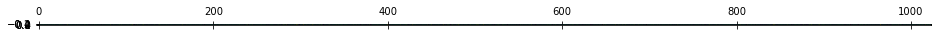

186 torch.Size([8, 1, 1024])


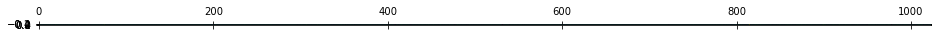

187 torch.Size([8, 1, 1024])


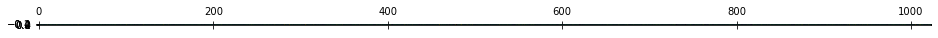

188 torch.Size([8, 1, 1024])


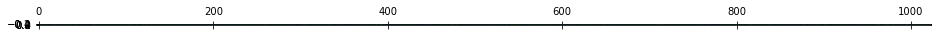

189 torch.Size([8, 1, 1024])


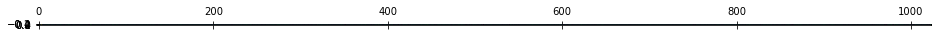

190 torch.Size([8, 1, 1024])


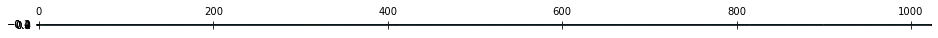

191 torch.Size([8, 1, 1024])


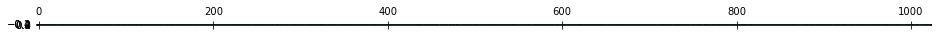

192 torch.Size([8, 1, 1024])


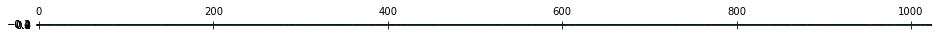

193 torch.Size([8, 1, 1024])


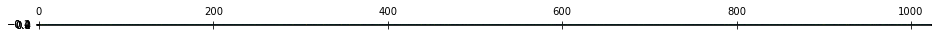

194 torch.Size([8, 1, 1024])


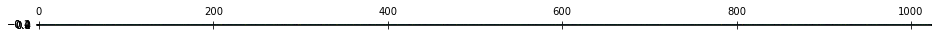

195 torch.Size([8, 1, 1024])


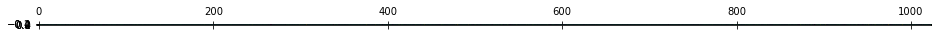

196 torch.Size([8, 1, 1024])


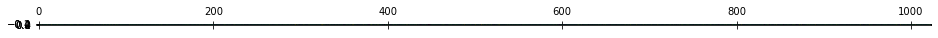

197 torch.Size([8, 1, 1024])


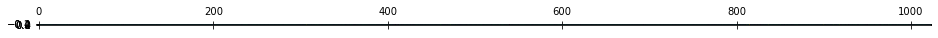

198 torch.Size([8, 1, 1024])


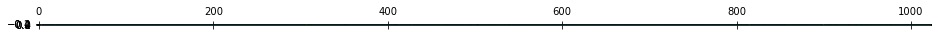

199 torch.Size([8, 1, 1024])


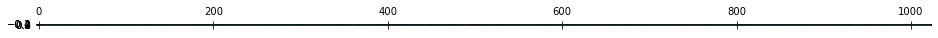

200 torch.Size([8, 1, 1024])


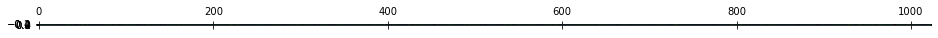

201 torch.Size([8, 1, 1024])


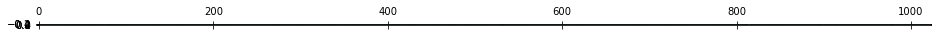

202 torch.Size([8, 1, 1024])


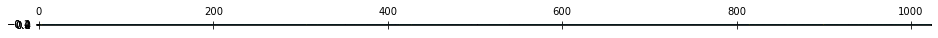

203 torch.Size([8, 1, 1024])


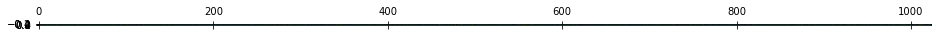

204 torch.Size([8, 1, 1024])


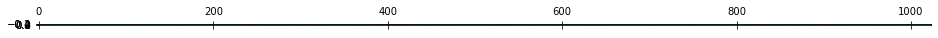

205 torch.Size([8, 1, 1024])


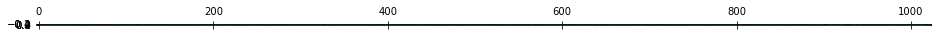

206 torch.Size([8, 1, 1024])


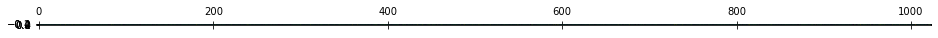

207 torch.Size([8, 1, 1024])


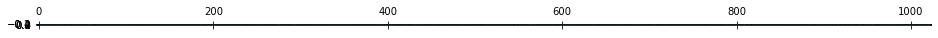

208 torch.Size([8, 1, 1024])


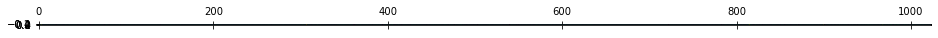

209 torch.Size([8, 1, 1024])


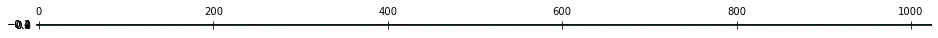

210 torch.Size([8, 1, 1024])


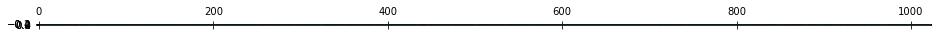

211 torch.Size([8, 1, 1024])


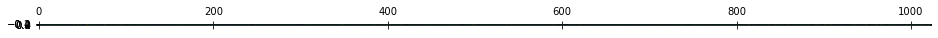

212 torch.Size([8, 1, 1024])


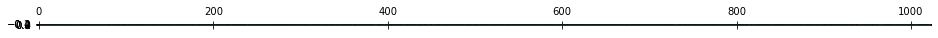

213 torch.Size([8, 1, 1024])


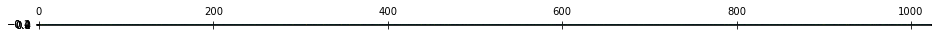

214 torch.Size([8, 1, 1024])


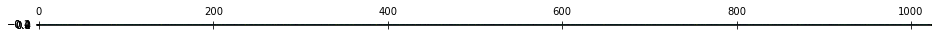

215 torch.Size([8, 1, 1024])


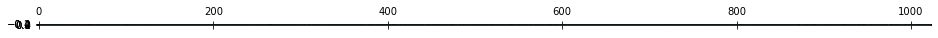

216 torch.Size([8, 1, 1024])


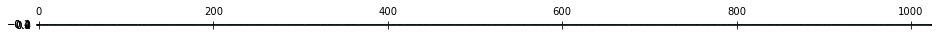

217 torch.Size([8, 1, 1024])


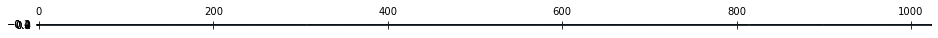

218 torch.Size([8, 1, 1024])


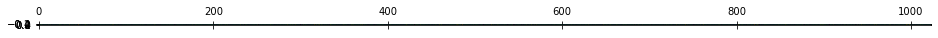

219 torch.Size([8, 1, 1024])


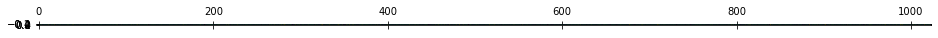

220 torch.Size([8, 1, 1024])


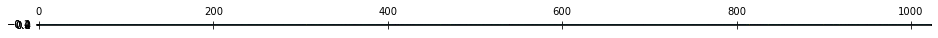

221 torch.Size([8, 1, 1024])


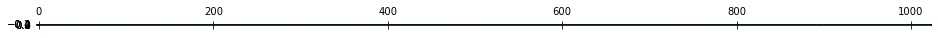

222 torch.Size([8, 1, 1024])


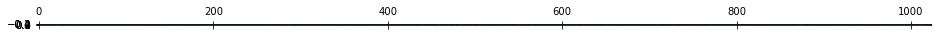

223 torch.Size([8, 1, 1024])


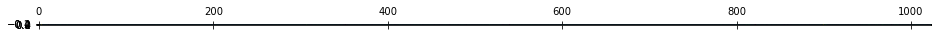

224 torch.Size([8, 1, 1024])


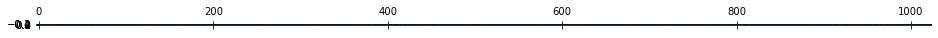

225 torch.Size([8, 1, 1024])


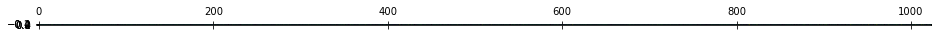

226 torch.Size([8, 1, 1024])


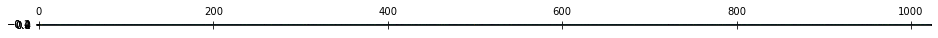

227 torch.Size([8, 1, 1024])


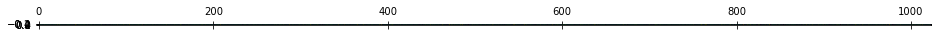

228 torch.Size([8, 1, 1024])


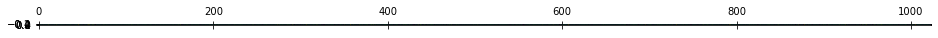

229 torch.Size([8, 1, 1024])


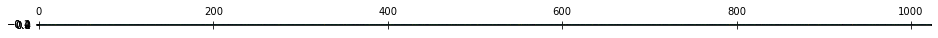

230 torch.Size([8, 1, 1024])


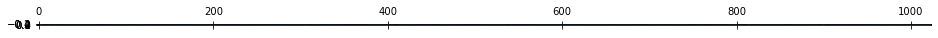

231 torch.Size([8, 1, 1024])


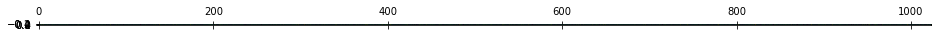

232 torch.Size([8, 1, 1024])


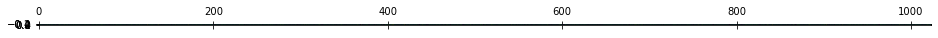

233 torch.Size([8, 1, 1024])


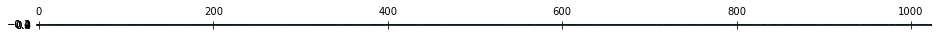

234 torch.Size([8, 1, 1024])


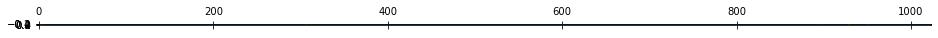

235 torch.Size([8, 1, 1024])


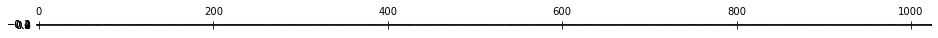

236 torch.Size([8, 1, 1024])


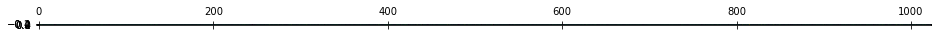

237 torch.Size([8, 1, 1024])


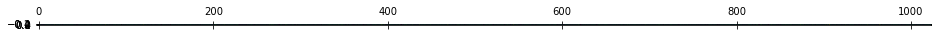

238 torch.Size([8, 1, 1024])


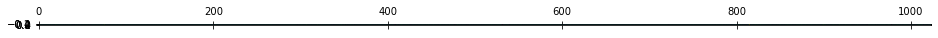

239 torch.Size([8, 1, 1024])


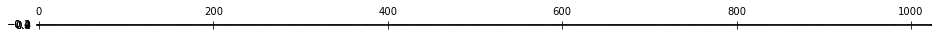

240 torch.Size([8, 1, 1024])


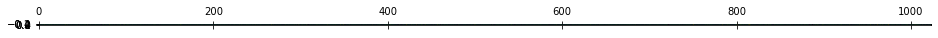

241 torch.Size([8, 1, 1024])


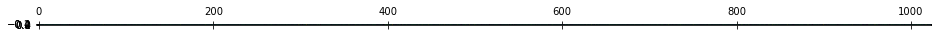

242 torch.Size([8, 1, 1024])


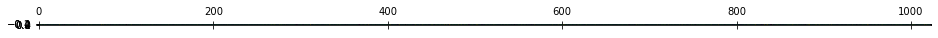

243 torch.Size([8, 1, 1024])


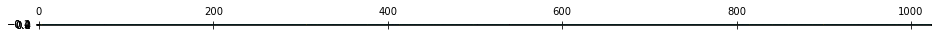

244 torch.Size([8, 1, 1024])


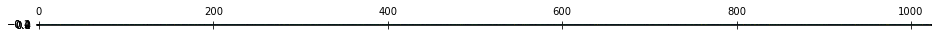

245 torch.Size([8, 1, 1024])


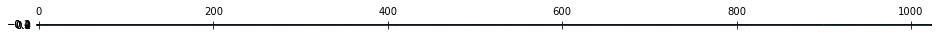

246 torch.Size([8, 1, 1024])


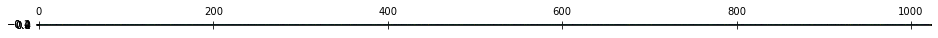

247 torch.Size([8, 1, 1024])


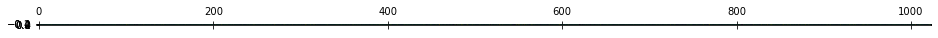

248 torch.Size([8, 1, 1024])


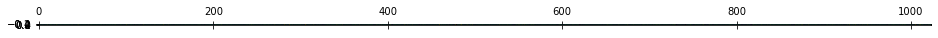

249 torch.Size([8, 1, 1024])


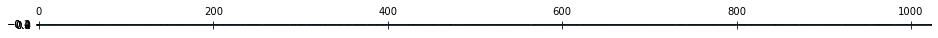

250 torch.Size([8, 1, 1024])


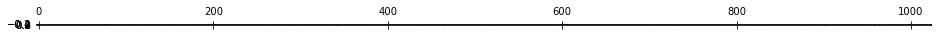

251 torch.Size([8, 1, 1024])


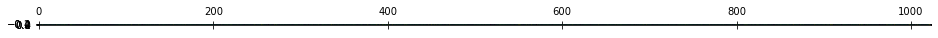

252 torch.Size([8, 1, 1024])


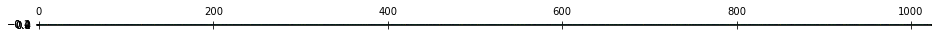

253 torch.Size([8, 1, 1024])


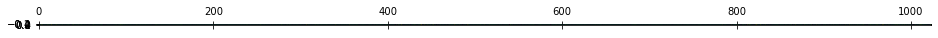

254 torch.Size([8, 1, 1024])


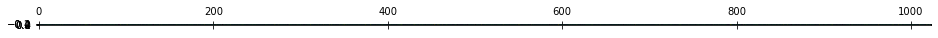

In [45]:
for i,hs in enumerate(out["decoder_hidden_states"]):
    for j,hss in enumerate(hs):
        print(i, hss.shape)
        t = hss.reshape(1,8,1024)
        t = hss[0].cpu().detach().numpy()
        plt.matshow(t)
        plt.show()
        break

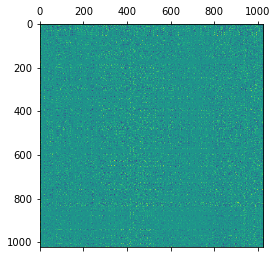

In [19]:

t = out.decoder_hidden_states[0][0].cpu().detach().numpy()

plt.matshow(t)

plt.show()

In [28]:
class SuperAttention(nn.Module):
    def __init__(self, embed_size, heads):
        """ 
            :param heads int, number of splits to split the embedding
        """
        super(SuperAttention, self).__init__()
        
        
        
    
    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm
        
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out

In [33]:
model2 = SuperAttention(embed_size=64, heads=4)


In [32]:
mask = torch.zeros([1,1024])
attn = model(batch["input_ids"], batch["input_ids"], batch["input_ids"], mask)

RuntimeError: shape '[1, 1024, 4, 16]' is invalid for input of size 1024

In [36]:
out = peg_model.base_model(batch["input_ids"], decoder_input_ids=batch["input_ids"])

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.78 GiB total capacity; 7.92 GiB already allocated; 5.75 MiB free; 7.93 GiB reserved in total by PyTorch)